##트랜스포머로 만드는 대화형 챗봇

개발 환경
<br/>데이터 정보
<br/>데이터 탐색

데이터 전처리
<br/>결측치 처리
<br/>데이터 분리
<br/>정규화
<br/>SubwordTextEncoder

모델 구성
<br/>Positional Encoding Layer
<br/>caled Dot Product Attention
<br/>Multi Head Attention
<br/>Padding Mask
<br/>Look Ahead Mask
<br/>Encoder
<br/>Decoder
<br/>Transformer

모델 학습
<br/>모델 평가
<br/>결론
<br/>참고문헌

# 개발 환경

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

tensorflow는 구글이 개발한 오픈소스 소프트웨어 딥러닝 및 머신러닝 라이브러리이다.
<br/>수학 계산식과 데이터의 흐름을 노드와 엣지를 사용한 방향성 그래프, 데이터 플로우 그래프로 나타낸다.

tfds는 텐서플로우에서 제공하는 데이터셋으로 모델을 연습하기에 용이하다.

os(Operating System)는 운영체제에서 제공되는 여러 기능을 파이썬에서 수행한다.
예를 들어, 파일 복사, 디렉터리 생성, 파일 목록을 구할 수 있다.

pandas는 행과 열로 이루어진 데이터 객체를 만들어 안정적으로 대용량의 데이터들을 처리한다.

numpy는 array 단위로 벡터와 행렬을 계산한다.

re(regex)는 특정 문자 또는 문자열이 존재하는지나 어느 위치에 있는지와 같은 기능을 제공하는 정규표현식 라이브러리이다.

 matplotlib은 시각화를 한다.

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git

Py-Hanspell은 네이버 한글 맞춤법 검사기를 바탕으로 만들어진 패키지이다.

In [ ]:
!pip install soynlp

soynlp는 미등록 단어를 번거롭게 사전에 등록할 필요가 없는 통계 기반 비지도학습 한글 라이브러리이다.
<br/>문장을 단어열로 분해하거나 품사 판별을 한다.

In [ ]:
from hanspell import spell_checker
from soynlp.normalizer import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['pandas=', 'numpy=', 'matplotlib=', 'sklearn=', 'tensorflow=', 'sklearn', 'regex=', 'hanspell', 'soynlp']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

matplotlib==3.2.2      numpy==1.21.6      pandas==1.3.5     
py-hanspell @ git+https://github.com/ssut/py-hanspell.git@8e993cf46f97f9d665c15633a0fc78ac1b727713      regex==2022.6.2      sklearn==0.0     
sklearn==0.0      sklearn-pandas==1.8.0      sklearn-pandas==1.8.0     
soynlp==0.0.493      tensorflow==2.8.2+zzzcolab20220527125636     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보

[Chatbot data for Korean v1.0](https://github.com/songys/Chatbot_data)

다음 카페 [사랑보다 아름다운 실연](http://cafe116.daum.net/_c21_/home?grpid=1bld)에서 자주 나오는 이야기들을 참고하여 제작한 데이터이다.

챗봇 트레이닝용 문답 페어가 11,876개이다.
<br/>일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링했다.

# 데이터 탐색

In [ ]:
Chatbot_data = pd.read_table('/content/drive/MyDrive/lms/transformer_chatbot/ChatbotData.csv')
Chatbot_data.head()

,"Q,A,label"
0,"12시 땡!,하루가 또 가네요.,0"
1,"1지망 학교 떨어졌어,위로해 드립니다.,0"
2,"3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0"
3,"3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0"
4,"PPL 심하네,눈살이 찌푸려지죠.,0"


In [ ]:
Chatbot_split = Chatbot_data["Q,A,label"].str.split(',')
Chatbot_split = Chatbot_split.apply(lambda x: pd.Series(x))
Chatbot_split = Chatbot_split.loc[:, [0, 1]]
Chatbot_split.columns = ['Q', 'A']

In [ ]:
Chatbot_split

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


#데이터 전처리

##결측치 처리

In [ ]:
Chatbot_split.isnull()

,Q,A
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
11818,False,False
11819,False,False
11820,False,False
11821,False,False


##데이터 분리

In [ ]:
Q_train, Q_test, A_train, A_test = train_test_split(Chatbot_split['Q'], Chatbot_split['A'], test_size= 0.2, random_state=1234)

In [ ]:
train_data = pd.concat([Q_train, A_train] , axis=1)
test_data = pd.concat([Q_test, A_test] , axis=1) 

In [ ]:
print('전체 샘플 수 :', len(Chatbot_data))
print('훈련 샘플 수 :', len(train_data))
print('시험 샘플 수 :', len(test_data))

전체 샘플 수 : 11823
훈련 샘플 수 : 9458
시험 샘플 수 : 2365


##정규화

In [ ]:
def preprocess_sentence(sentence):
  new_sent = spell_checker.check(sentence)
  spell_sent = new_sent.checked
  sentence = emoticon_normalize(spell_sent,  num_repeats=2)
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)

  return sentence

Py-Hanspell은 한글 맞춤법 검사를 한다. 띄어쓰기 보정도 한다.
<br/>soynlp는 이모티콘(ㅋㅋ, ㅎㅎ)과 같이 불필요하게 연속되는 것을 2개의 반복으로 정규화한다.

단어와 구두점(punctuation) 사이의 거리를 만든다.
<br/>가-힣, a-z, A-Z, ".", "?", "!", ","를 제외한 모든 문자를 공백인 ' '로 대체한다.

In [ ]:
def load_conversations():

  inputs, outputs = [], []

  for i in range(len(train_data) - 1):
    inputs.append(preprocess_sentence(train_data.iloc[i]['Q']))
    outputs.append(preprocess_sentence(train_data.iloc[i]['A']))

  return inputs, outputs

In [ ]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 9457
전체 샘플 수 : 9457


In [ ]:
print('전처리 후의 11번째 질문 샘플: ', preprocess_sentence(questions[10]))
print('전처리 후의 11번째 답변 샘플: ', preprocess_sentence(answers[10]))

전처리 후의 11번째 질문 샘플:  재회를 기다리다 단념하게 된 이유가 뭐였나 ? 
전처리 후의 11번째 답변 샘플:  똑같은 일이 반복될까 봐 두려웠던 거겠죠 . 


전처리하여 질문을 questions, 답변을 answers에 저장한다.

##SubwordTextEncoder

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

질문과 답변 데이터셋에 대해서 Vocabulary를 생성한다.

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

시작 토큰과 종료 토큰에 고유한 정수를 부여한다.

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8208]
END_TOKEN의 번호 : [8209]


In [ ]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8210


시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정한다.

In [ ]:
print('정수 인코딩 후의 3번째 질문 샘플: {}'.format(tokenizer.encode(questions[2])))
print('정수 인코딩 후의 3번째 답변 샘플: {}'.format(tokenizer.encode(answers[2])))

정수 인코딩 후의 3번째 질문 샘플: [303, 682, 9, 213, 1]
정수 인코딩 후의 3번째 답변 샘플: [322, 1]


임의의 3번째 샘플에 대해서 정수 인코딩 작업을 수행한다.
<br/>각 토큰을 고유한 정수로 변환한다.

In [ ]:
temp = []
for q in answers: 
    if len(q) < 40:
        temp.append(q)
print(len(temp)/len(answers))

0.9900602728137887


In [ ]:
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [ ]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩을 한다.
<br/>정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가한다.
<br/>최대 길이 40이하인 경우에만 데이터셋으로 허용한다.
<br/>최대 길이 40으로 모든 데이터셋을 패딩한다.

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8210
필터링 후의 샘플 개수: 9457
필터링 후의 샘플 개수: 9457


#모델 구성

##Positional Encoding Layer

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

배열의 짝수 인덱스에는 sin 함수를 적용한다.
<br/>배열의 홀수 인덱스에는 cosine 함수를 적용한다.

##Scaled Dot Product Attention

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

##Multi Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    outputs = self.dense(concat_attention)

    return outputs

linear layers로 query, key, value를 구성한다.
<br/>병렬 연산을 위한 머리를 여러 개 만든다.
<br/>scaled_dot_product_attention 함수에 linear layers(query, key, value)를 불러온다.
<br/>어텐션 연산 후에 각 결과를 다시 연결(concatenate)한다.
<br/>dense는 final linear layer를 구성한다.

##Padding Mask

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

##Look Ahead Mask

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

##Encoder

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
          })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 하나의 레이어 안에는 두 개의 서브 레이어가 존재한다.

Padding Mask를 사용한다.

첫번째 서브 레이어에서는 Multi Head Attention를 수행한다.
<br/>어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행한다.

두번째 서브 레이어는 2개의 완전연결층으로 구성된다.
<br/>완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행한다.

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

Padding Mask를 사용한다.
<br/>Embedding Layer를 구성한다.
<br/>Positional Encoding을 한다.
<br/>인코더의 층을 num_layers만큼 쌓아올린다.

##Decoder

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
          })

    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
              'query': attention1,
              'key': enc_outputs,
              'value': enc_outputs,
              'mask': padding_mask
          })

  
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

디코더 하나의 레이어 안에는 세 개의 서브 레이어가 존재한다.

첫번째 서브 레이어에서는 Multi Head Attention를 수행한다.
<br/>어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행한다.

두번째 서브 레이어는 Masked Multi Head Attention를 수행한다.
<br/>어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행한다.

세번째 서브 레이어는 2개의 완전연결층으로 구성된다.
<br/>완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행한다.

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

Padding Mask를 사용한다.
<br/>Embedding Layer를 구성한다.
<br/>Positional Encoding을 한다.
<br/>Dropout이라는 훈련을 돕는 테크닉을 수행
<br/>인코더의 층을 num_layers만큼 쌓아올린다.

##Transformer

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

디코더는 이전의 target을 다음의 input으로 사용한다.
<br/>이에 따라 outputs에서는 START_TOKEN을 제거한다.

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

인코더에서 Padding Mask를 구성한다.

Look Ahead Mask는 코더에서 미래의 토큰을 마스킹한다.
<br/>내부적으로 Padding Mask도 포함된다.

디코더에서 Padding Mask를 구성한다.
<br/>두번째 어텐션 블록에서 인코더의 벡터들을 마스킹한다.


인코더, 디코더, 완전연결층을 구성한다.

#모델 학습

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_LAYERS = 2 
D_MODEL = 256 
NUM_HEADS = 8
UNITS = 512 
DROPOUT = 0.1

하이퍼파라미터를 조정한다.

인코더와 디코더의 층의 개수
<br/>인코더와 디코더 내부의 입, 출력의 고정 차원
<br/>멀티 헤드 어텐션에서의 헤드 수 
<br/>피드 포워드 신경망의 은닉층의 크기
<br/>드롭아웃의 비율

In [ ]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3155968     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
148/148 [==============================] - 16s 57ms/step - loss: 1.4610 - accuracy: 0.0213
Epoch 2/20
148/148 [==============================] - 8s 56ms/step - loss: 1.2452 - accuracy: 0.0476
Epoch 3/20
148/148 [==============================] - 8s 56ms/step - loss: 1.0475 - accuracy: 0.0502
Epoch 4/20
148/148 [==============================] - 8s 56ms/step - loss: 0.9495 - accuracy: 0.0520
Epoch 5/20
148/148 [==============================] - 8s 56ms/step - loss: 0.8937 - accuracy: 0.0560
Epoch 6/20
148/148 [==============================] - 8s 56ms/step - loss: 0.8426 - accuracy: 0.0596
Epoch 7/20
148/148 [==============================] - 8s 56ms/step - loss: 0.7906 - accuracy: 0.0630
Epoch 8/20
148/148 [==============================] - 8s 56ms/step - loss: 0.7351 - accuracy: 0.0682
Epoch 9/20
148/148 [==============================] - 8s 56ms/step - loss: 0.6742 - accuracy: 0.0745
Epoch 10/20
148/148 [==============================] - 8s 56ms/step - loss: 0.6090 - accur

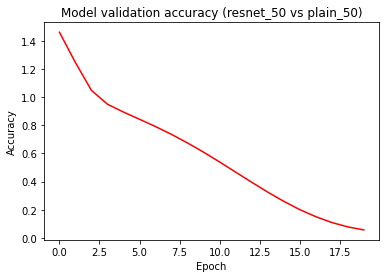

In [ ]:
plt.plot(history.history['loss'], 'r')
plt.title('Model validation accuracy (resnet_50 vs plain_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

loss가 1.4610에서 0.0568으로 떨어지며 안정적으로 수렴한다.

#모델 평가

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output_sequence = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

output_sequence는 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수이다.
<br/>처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장한다.

디코더의 인퍼런스 단계에서는 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복하며
<br/>현재 예측한 단어의 정수를 연산한다.
<br/>만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료한다.

예측한 단어들은 지속적으로 output_sequence에 추가된다.
<br/>이 output_sequence는 다시 디코더의 입력이 된다.

In [ ]:
def sentence_generation(sentence):
  prediction = decoder_inference(sentence)
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  return predicted_sentence

입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받는다.
<br/>정수 시퀀스를 다시 텍스트 시퀀스로 변환한다.

In [ ]:
for i in range(10):
    print('질문 입력 : {}'.format(test_data.iloc[i]['Q']))
    print('예측 출력 : {}'.format(sentence_generation(test_data.iloc[i]['Q'])))
    print('정답 출력 : {}'.format(test_data.iloc[i]['A']))
    print('-'*25)

질문 입력 : 하루종일 썸남 생각만 해. 괜찮을까?
예측 출력 : 감정 소모가 꽤 돼요 . 
정답 출력 : 그것 또한 감정의 일부니까요.
-------------------------
질문 입력 : 냉장고에 먹을 게 하나도 없네
예측 출력 : 장 보러 가봅시다 . 
정답 출력 : 슈퍼라도 가서 쇼핑하고 오세요.
-------------------------
질문 입력 : 인사드리러 갔는데 파혼하는게 나을것 같아
예측 출력 : 어떤 이별이든 후폭풍이 있는 것 같아요 . 
정답 출력 : 이혼이 아니라 다행입니다.
-------------------------
질문 입력 : 금값 어때
예측 출력 : 비싸요 . 
정답 출력 : 비싸요.
-------------------------
질문 입력 : 연애상담하더니 둘이 사귀더라
예측 출력 : 상황이 생각을 바뀌게 하기도 합니다 . 
정답 출력 : 대화를 하다가 친해졌나봐요.
-------------------------
질문 입력 : 혼자 노래방 가면 어색할 거 같은데
예측 출력 : 신나는 노래를 들려주세요 . 
정답 출력 : 신나는 노래로 분위기를 띄어보세요.
-------------------------
질문 입력 : 기회도 없네.
예측 출력 : 행운을 빌게요 ! 
정답 출력 : 다른 기회가 올 거예요.
-------------------------
질문 입력 : 사랑한 만큼 배려해야했어
예측 출력 :  이야기보다 가슴 먹먹할 거예요 . 
정답 출력 : 이제야 깨달았나봐요.
-------------------------
질문 입력 : 여자친구가 전화를 안해
예측 출력 : 다른 연락을 많이 하거나 더 자주 만나세요 . 
정답 출력 : 다른 연락을 많이 하거나 더 자주 만나세요.
-------------------------
질문 입력 : 못생긴 남자를 좋아하는 여자가 있을지.
예측 출력 : 직접 말할 때까지 조금 기다려주세요 . 
정답 출력 : 외모가 중요한 시대는 끝났어요.
------------------------


#결론

**모델 훈련**

loss가 1.4610에서 0.0568으로 떨어지며 안정적으로 수렴한다.

**정답 문장과 예측 결과 비교**

시험 데이터에서 10번째 문장까지 입력한 결과 그럴듯한 한국어로 답변을 리턴하였다.
<br/>정답과 똑같은 어휘 혹은 비슷한 의미를 가진 어휘를 사용한 문장이 출력됐다.
<br/>2개의 엉뚱하거나 어색한 의미의 문장이 출력되기도 했다.

**여담**

앞으로 NLP 모델을 공부하면서 코드에 대한 설명을 추가할 예정이다.
<br/>밑바닥부터 시작한 딥러닝 2권 1회독을 하고 1차 수정을 한다.
<br/>Attention Is All You Need 논문을 정독하고 2차 수정을 한다.

#참고문헌

**LMS**
<br/>[ukairia777](https://github.com/ukairia777)

<br/>**논문**
<br/>[이재경, 서진범, 조영복, 「한글 토크나이징 라이브러리 모듈 분석」, 한국정보통신학회, 『2021년 춘계 종합학술대회 논문집』, 2021, p.78~80](http://koreascience.or.kr/journal/HOJBAV/y2021m05a.page?&lang=ko)

<br/>**단행본**
<br/>유원준 외 1명, 『딥러닝을 이용한 자연어 처리 입문』, Wikidocs, 2022
<br/>[한국어 전처리 패키지(Text Preprocessing Tools for Korean Text)](https://wikidocs.net/92961)

<br/>**깃허브**
<br/>[Chatbot data for Korean v1.0](https://github.com/songys/Chatbot_data)
<br/>[py-hanspell](https://github.com/ssut/py-hanspell)
<br/>[soynlp](https://github.com/lovit/soynlp)

<br/>**웹사이트**
<br/>[다음 카페 사랑보다 아름다운 실연](http://cafe116.daum.net/_c21_/home?grpid=1bld)
<br/>[Tensorflow Datasets(tfds) 사용하기](https://somnio100.tistory.com/100)
<br/>[stackoverflow : module 'tensorflow_datasets.core.features' has no attribute 'text'](https://stackoverflow.com/questions/65397061/module-tensorflow-datasets-core-features-has-no-attribute-text)